In [8]:
import os 
from glob import glob 
import dicom2nifti
import pandas as pd 
import matplotlib.pyplot as plt 
import sklearn
print(sklearn.__version__)
# from sklearn.mode_selection import train_test_split 
import numpy as np 

import torch 
import torchio as tio 
import torchvision 
import skimage 
from skimage import color 
from torch.utils.data import DataLoader 


1.1.1


/ubc/ece/home/ra/other/manmeetp/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
#storing the DICOM files in the .nii.gz format for easier image processing
files_error = list()

dicom_input = "ordered_data/CT_Lymph_Nodes"
nifti_output = "3D_volumes_NIfTI_images"

folder = glob(dicom_input + '/*')
files_not_done = []
print(os.listdir(nifti_output))
# print(folder)

try:
    for name, patient in zip(os.listdir(dicom_input), folder):
        file_name = str(name + ".nii.gz")
        if (file_name not in os.listdir(nifti_output)):
            print(name)
            print(patient)
            dicom2nifti.dicom_series_to_nifti(patient, os.path.join(nifti_output, name + ".nii.gz"))
        else: 
            files_not_done.append(name)
            print("error")
except Exception as e:
    print(e)
    files_error.append(name)
    pass 

(files_error)


['ABD_LYMPH_007.nii.gz', 'ABD_LYMPH_069.nii.gz', 'ABD_LYMPH_033.nii.gz', 'ABD_LYMPH_019.nii.gz', 'MED_LYMPH_067.nii.gz', 'MED_LYMPH_002.nii.gz', 'MED_LYMPH_017.nii.gz', 'ABD_LYMPH_084.nii.gz', 'MED_LYMPH_026.nii.gz', 'MED_LYMPH_064.nii.gz', 'MED_LYMPH_073.nii.gz', 'MED_LYMPH_075.nii.gz', 'ABD_LYMPH_016.nii.gz', 'MED_LYMPH_069.nii.gz', 'MED_LYMPH_066.nii.gz', 'MED_LYMPH_055.nii.gz', 'MED_LYMPH_024.nii.gz', 'ABD_LYMPH_064.nii.gz', 'ABD_LYMPH_005.nii.gz', 'MED_LYMPH_085.nii.gz', 'ABD_LYMPH_028.nii.gz', 'ABD_LYMPH_021.nii.gz', 'MED_LYMPH_029.nii.gz', 'MED_LYMPH_081.nii.gz', 'ABD_LYMPH_078.nii.gz', 'MED_LYMPH_063.nii.gz', 'MED_LYMPH_030.nii.gz', 'ABD_LYMPH_036.nii.gz', 'MED_LYMPH_044.nii.gz', 'ABD_LYMPH_015.nii.gz']
ABD_LYMPH_013
ordered_data/CT_Lymph_Nodes/ABD_LYMPH_013


Slice increment not consistent through all slices
---------------------------------------------------------
[-177.     16.   -211.25] [ 0.    0.   -1.25]
[-177.     16.   -208.75] [ 0.   0.  -2.5]
Instance Number: 382
---------------------------------------------------------


SLICE_INCREMENT_INCONSISTENT


['ABD_LYMPH_013']

In [10]:
#WHERE DID HALF OF THE FILES GO?
    

ordered_data/CT_Lymph_Nodes/MED_LYMPH_063


In [ ]:
#now we apply isotropic resampling to the images to get a voxel spacing of 1mm in each direction

import nibabel as nib

#THIS METHOD WILL OVERWRITE THE FILES IN DATA BUT CREATE A NEW FOLDER FOR THE MASKS 
#the actual data
image_folder = "3D_volumes_NIfTI_images"
dest_input_folder = "resampled_input_data"

for image in os.listdir(image_folder):
    affine_matrix = nib.load(os.path.join(image_folder, image)).affine

    input = tio.ScalarImage(os.path.join(image_folder, image), to_mni=affine_matrix)
    transform = tio.Resample(1, pre_affine_name='to_mni')
    isotropic_image = transform(input)
    print(np.shape(isotropic_image))

    padding = tio.CropOrPad(target_shape=[512, 512, np.shape(isotropic_image)[3]])
    padded_image = padding(isotropic_image)
    print(np.shape(padded_image))

    tio.Image.save(padded_image, path=os.path.join(dest_input_folder,  image))
    print("ressssaaaampled")


In [ ]:
#the corresponding mask
#the masks are all 512x512xdepth dimension so we can str8 up apply preprocessing to these 
import nibabel as nib
mask_folder = "MED_ABD_LYMPH_MASKS" 
for folders in os.listdir(mask_folder):
    mask_file = os.listdir(os.path.join(mask_folder, folders))[0]
    mask_array = nib.load(os.path.join(os.path.join(mask_folder, folders), mask_file)).get_data()
    print(np.shape(mask_array))

/tmp/ipykernel_25583/649193978.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  test_image=nib.load(img_path).get_data()


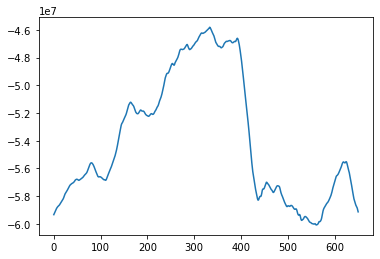

In [4]:
#making sure that the resampled files aren't corrupt 
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np 

img_path = "resampled_input_data/ABD_LYMPH_028.nii.gz"
test_image=nib.load(img_path).get_data()
# test_image *= 255
# test_image = (test_image - np.min(test_image)) / (np.max(test_image) - np.min(test_image))
test_sum = np.sum(test_image, axis=(0, 1))
plt.plot(test_sum)

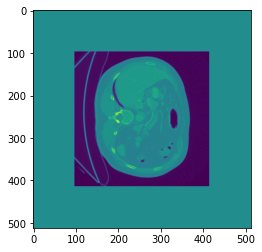

In [5]:
#this shows the resampled image which has isotropic spacing and padding on the edges
plt.imshow(test_image[:, :, 350])